# Reduction of GIANO data

In [1]:
#------ manually fix import for now
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.align import Align
from redcross.planet import Planet

def sysrem_evolution(snr_sys, outname=None):
    '''given a matrix with (SysRem iteration, SNR) 
    plot the evolution and highlight the max SNR'''
    sys_i = snr_sys.T[0]
    snr_i = snr_sys.T[1]

    fig, ax = plt.subplots(1, figsize=(9,4))
    ax.plot(sys_i, snr_i, '--', c='gray')
    ax.plot(sys_i, snr_i, 'o', markersize=7, c='k')

    snr_max = snr_i.max()
    ax.scatter(sys_i[snr_i.argmax()], snr_i.max(), marker='*', 
               color='orange', s=250, zorder=10, 
               label='Max SNR = {:.2f} \nn = {:.0f}'.format(snr_i.max(), sys_i[snr_i.argmax()]))
    ax.set(xlabel='SysRem iteration', ylabel='SNR', title='Evolution of SNR with SysRem iterations')
    ax.legend()
    plt.show()
    if outname != None:
        fig.savefig(outname, dpi=200, bbox_inches='tight', facecolor='white')
    return None

c = 2.99e5
%load_ext autoreload
%autoreload 2

## Load FITS files

In [9]:
night = '2'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)

# dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))

read_from_files = False # set to `True` the first time running it

if read_from_files:
    files = sorted(glob.glob(data_dir+'*_{:}_*.fits'.format(position))) # select files
    dc = read_giano(files)
    dc.save(data_dir+'datacube_input_pos{:}.npy'.format(position))
else:
    dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))
    
dc.flux_err[dc.flux_err==0.] = np.nan
    
planet = Planet('wasp189', **dc.get_header().header)

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night2/posB/datacube_input_posB.npy


In [10]:
def prange(planet, key):
    attr = getattr(planet, key)
    displ_list = [attr[0], attr[int(len(attr)/2.)], attr[-1]]
    print('{:10}: {:.2f} - {:.2f} - {:.2f}'.format(key, *displ_list))
    return None


prange(planet, 'phase')
prange(planet, 'airmass')


GeodeticLocation(lon=<Longitude -17.88 deg>, lat=<Latitude 28.75833333 deg>, height=<Quantity 2327. m>)
phase     : 0.39 - 0.45 - 0.50
airmass   : 2.05 - 1.18 - 2.16


### Display average FLUX and AIRMASS per frame

total/in-eclipse
84 / 0


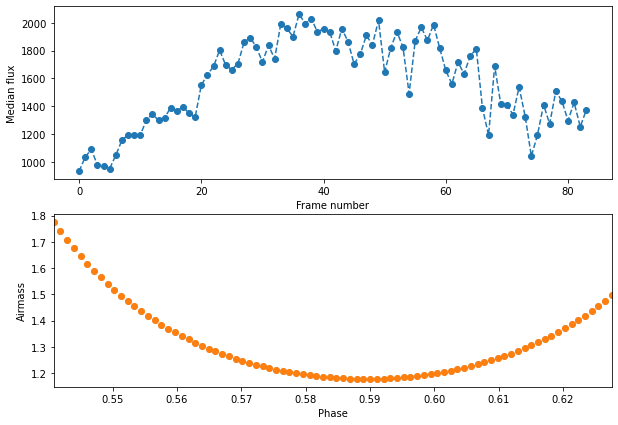

In [3]:
fig, ax = plt.subplots(2,1, figsize=(10,7))

flux = np.median(dc.flux, axis=(0,2))
ax[0].plot(np.arange(0, dc.nObs), flux ,'--o')

ax[1].plot(planet.phase, dc.airmass,'o', alpha=0.3)
ax[1].plot(planet.phase, dc.airmass,'o')
ax[1].axvspan(0.46, 0.54, alpha=0.1, color='red', label='Eclipse')
ax[1]

ax[0].set(ylabel='Median flux', xlabel='Frame number')
ax[1].set(xlabel='Phase', ylabel='Airmass', xlim=(planet.phase.min(), planet.phase.max()))

# how many frames are in-eclipse
ecl = planet.phase > 0.47
print('total/in-eclipse')
print('{:} / {:}'.format(planet.phase.size, planet.phase[~ecl].size))

# discard frames with very-low flux
# mask = flux < 200
# bad_files = int(np.argwhere(mask==True)[0])
# files[bad_files]

### Read atmospheric template (from petitRADTRANS)

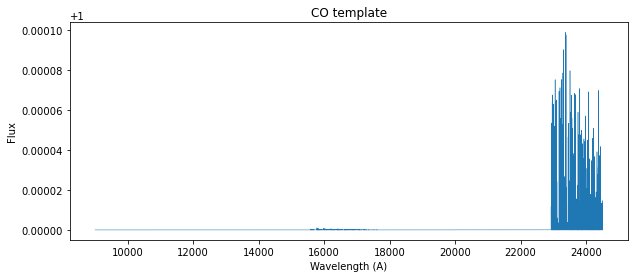

In [4]:
# species = 'OH_main_iso'
species = 'CO_main_iso'
species_name = species.split('_')[0]
template_path = 'data/template_giano_{:}_2500K.npy'.format(species)
twave, tflux = np.load(template_path)

# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

# plot template
fig, ax = plt.subplots(1, figsize=(10,4))
template.plot(ax=ax, lw=0.5)
ax.set(xlabel='Wavelength (A)', ylabel='Flux', title='{:} template'.format(species_name))
plt.show()

### Load wavelength solution from TelFit
Store the median wavelength solution for each order in the matrix `wavesol`

*Note: Values in nm*

In [5]:
data_dir

'/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/'

In [6]:
orders = [48, 49]
pixels = np.arange(0, 2048)
wavesol = np.ones((len(orders), pixels.size))


for k,order in enumerate(orders):
    telfit_files = glob.glob('/home/dario/AstronomyLeiden/MRP/wavecal/output/order{0:}/telfit_order{0:}_frame*'.format(order))

    data, model = (Datacube() for _ in range(2))
    data.wlt, model.wlt, data.flux,  model.flux = (np.nan * np.ones((len(telfit_files), 2048)) for _ in range(4))

    for i,file in enumerate(telfit_files):

        pix, dwave, mwave, dflux, cont, mflux, _ = np.loadtxt(file).T
        pix = pix.astype(int)
        data.wlt[i,pix], model.wlt[i,pix], data.flux[i,pix], model.flux[i,pix] = dwave, mwave, dflux/cont, mflux
    telfit_sol = np.median(model.wlt, axis=0)
    # get wavelength solution for the whole range (fit over nans)
    nans = np.isnan(telfit_sol)
    polyfit = np.polyfit(pixels[~nans], telfit_sol[~nans], 3) 
    wavesol[k,:] = np.poly1d(polyfit)(pixels)*10 # from nm to Ansgtroms
    
#     np.savetxt(data_dir+'../wavesol_order{:}.dat'.format(order), wavesol[k,:])


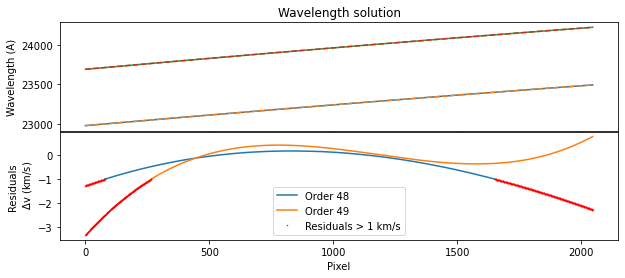

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10,4))
plt.subplots_adjust(hspace=0.01)
orders = [48,49]
res_labels = ['', 'Residuals > 1 km/s']
for i,order in enumerate(orders):
    ws = wavesol[order-48,:]
    giano_ws = np.median(dc.order(order).wlt, axis=0)
    ax[0].plot(pixels, ws)
    ax[0].plot(pixels, giano_ws, ls='--')


    cenwave = np.median(ws)
    c = 2.99e5
    res = c*(ws-giano_ws) / cenwave
    mask = np.abs(res) > 1
    ax[1].plot(pixels[~mask], res[~mask], label='Order {:}'.format(order))

    ax[1].plot(pixels[mask], res[mask], '.r', ms=1., label=res_labels[i])

ax[0].set(ylabel='Wavelength (A)', title='Wavelength solution')
ax[1].set(xlabel='Pixel', ylabel='Residuals \n $\Delta$v (km/s)')
ax[1].legend()
plt.show()
# fig.savefig('plots/wavesol_residuals.png', dpi=200, bbox_inches='tight', facecolor='white')

In [9]:
# order = 49
# dcs = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position)).order(order)
# fig, ax = plt.subplots(9,1,figsize=(10, 16))
# plt.subplots_adjust(hspace=0.01)
# dcs.imshow(ax=ax[0])
# print(dcs.wlt.shape)
# dcs.common_wave_grid(poly1d*10)

# # dcs.common_wave_grid(wavesol[50-order]*10)
# print(dcs.wlt.shape)

# dcs.imshow(ax=ax[1])

# debug = True
# # # dcs = dcs.split_orders(debug=True)
# x = int(dcs.nPix/2)
# print(dcs.wlt.shape)
# dcs.wlt = np.stack([dcs.wlt[x:], dcs.wlt[:x]])
# sort = np.argsort(np.nanmedian(dcs.wlt, axis=1))

# dcs.wlt = dcs.wlt[sort,:]
# dcs.flux = np.stack([dcs.flux[:,x:], dcs.flux[:,:x]])[sort,:,:]
# dcs.flux_err = np.stack([dcs.flux_err[:,x:], dcs.flux_err[:,:x]])[sort,:,:]

# dco = dcs.order(0).remove_continuum(mode='polyfit')
# dco.imshow(ax=ax[2])
# dco.sigma_clip(debug=debug)
# dco.imshow(ax=ax[3])
# dco.airmass_detrend()
# dco.imshow(ax=ax[4])

# dco.mask_cols(sigma=1.2, mode='flux', nan=True, debug=debug)
# dco.mask_cols(sigma=1.2, mode='flux_err', nan=True, debug=debug)
# dco.imshow(ax=ax[5])

# nSysRem = 4
# if nSysRem > 0.:
#     dco.sysrem(nSysRem)
# dco.imshow(ax=ax[6])
# #     # 5. High-pass filter
# dco.high_pass_gaussian(15, 'subtract')
# dco.imshow(ax=ax[7])

# #     # 6. Sigma-clip again
# dco.sigma_clip(nSigma=3., debug=debug)
# dco.imshow(ax=ax[8])


Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/datacube_input_posB.npy
(2, 84, 2048)
(4, 84, 1024)
---5/15----


mkdir: cannot create directory ‘plots/giano_CO_night1_posB_wavecal_nointerp/’: File exists


outliers = 6.51e-04 %
--> 15.53 % of pixels masked
outliers = 6.52e-03 %
--> 4.59 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 818


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


outliers = 5.93e-04 %
--> 20.02 % of pixels masked
outliers = 6.25e-03 %
--> 6.25 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 755
outliers = 9.88e-04 %
--> 18.65 % of pixels masked
outliers = 8.82e-03 %
--> 5.08 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 781
23.37 % of pixels have been masked
Horizontal slice at Kp = 194.5 km/s
Vertical slice at Vrest = 1.0 km/s


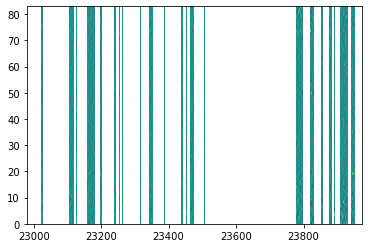

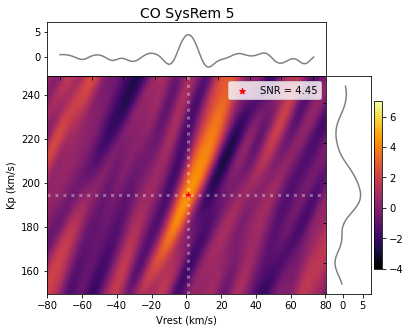

In [35]:
def reduce_giano(dco_in, nSysRem=3, hpw=15, debug=False):
    dco = dco_in.copy()
    good_in = dco.wlt[~np.isnan(dco.wlt)].size
    
    dco.remove_continuum(mode='polyfit').sigma_clip(debug=debug)#.airmass_detrend()
    
#     # TESTING
#     dco.mask_cols(sigma=2., mode='flux', nan=True, debug=debug)
    dco.mask_cols(sigma=1.2, mode='flux_err', nan=True, debug=debug)
#     # 4. SysRem
    if nSysRem > 0.:
        dco.sysrem(nSysRem)
#     # 5. High-pass filter
    dco.high_pass_gaussian(hpw, 'subtract').sigma_clip(nSigma=3., debug=debug)
#     dco.mask_cols(sigma=3., mode='flux_err', nan=True, debug=debug)
    dco.mask_cols(sigma=1.5, mode='flux', nan=True, debug=debug)
    
    if debug:
        good_out = dco.wlt[~np.isnan(dco.wlt)].size
        print('Initial pixel channels = {:}'.format(good_in))
        print('Output pixel channels = {:}'.format(good_out))
        
    return dco

%matplotlib inline
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)
orders = [48, 49]

    
# Apply wavelength calibration 
dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position)).order(orders)
for i,o in enumerate(orders):
    dco = dc.order(i)
    dco.common_wave_grid(wavesol[i])
    dc.flux[i,:] = dco.flux
    
dc.wlt = wavesol
dcs = dc.split_orders(debug=True)

# Define parameters for cross-correlation and Kp-Vsys map
hpw = 15
# dRV = 2.7
dRV = 1.5
RVt = np.arange(-350,351, dRV)
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
v_range = [-4.,7.0] # fix color scale

# sysrem_its = np.arange(0,16)
sysrem_its = np.array([5])
snr_sys = np.zeros((sysrem_its.size,2))

# save sequence
create_gif = False
folder = 'plots/giano_{:}_night{:}_pos{:}_wavecal_nointerp/'.format(species.split('_')[0], night, position)
os.system("mkdir {:}".format(folder))
for k,nsys in enumerate(sysrem_its):
    print('---{:}/15----'.format(nsys))
    wave, flux, flux_err = ([] for _ in range (3))    
#     for o in range(dcs.shape[0]):
    for o in range(3): 
#         print('Order {:}'.format(orders[0]+o))
        dco1 = reduce_giano(dcs.order(o), nsys, hpw, debug=True)
        

        wave.append(dco1.wlt) # changing the shape, can't overwrite for each order
        flux.append(dco1.flux)
        flux_err.append(dco1.flux_err)
    # Merge all reduced half-orders
    dcm = Datacube(flux=np.hstack(flux), wlt=np.hstack(wave), flux_err=np.hstack(flux_err))
    dcm.imshow()
    nans = np.isnan(dcm.wlt)
    frac_masked = nans[nans==True].size / nans.size
    print('{:.2f} % of pixels have been masked'.format(100*frac_masked))

#   Apply BERV correction (shift each frame)
    dcm.to_stellar_frame(-dcs.BERV) 
    
#   Run CCF and KpV 
    ccf = CCF(rv=RVt, template=template).run(dcm, weighted=True)
    kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)

    
    outname = folder+'sysrem-{:}.png'.format(nsys)
#     outname = None
    kpv.run().fancy_figure(peak=None, outname=outname, title='CO SysRem {:}'.format(nsys), v_range=v_range)
    snr_sys[k,] = np.array([nsys, kpv.peak_snr])

# save sysrem plot
# sysrem_evolution(snr_sys, outname=folder+'sysrem_evolution.png')



if create_gif:
    os.system("echo Generating animation with sequence...")
    os.system('ffmpeg -hide_banner -loglevel quiet -framerate 1 -i {:}-%00d.png -vcodec libx264 -vf \
              "pad=ceil(iw/2)*2:ceil(ih/2)*2" -r 24  -y -an {:}output.mp4'.format(outname.split('-')[0], folder))
    os.system('ffmpeg -i {0:}output.mp4 -r 15 -vf scale=512:-1 {0:}output.gif'.format(folder))   

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(1,figsize=(10,4))
dcm.imshow(ax=ax)
nans = np.isnan(dcm.wlt)
frac_masked = nans[nans==True].size / nans.size
print('{:.2f} % of pixels have been masked'.format(100*frac_masked))
plt.show()


In [ ]:
print(stop)
dRV = 1.6
RVt = np.arange(-350,351, dRV)

ccf = CCF(rv=RVt, template=template)
ccf.run(dcm, weighted=True)



fig, ax = plt.subplots(1,3,figsize=(14,4))

ccf.imshow(ax=ax[0])
ccf_shifted = ccf.to_planet_frame(planet)
ccf_shifted.imshow(ax=ax[1])
ax[2].plot(ccf_shifted.rv, np.median(ccf_shifted.flux, axis=0))

[ax[k].set_xlabel('RV (km/s)') for k in range(3)]
ax[0].set(ylabel='Frame number', title='CCF (stellar frame)')
ax[1].set(title='CCF (planetary frame)')
ax[2].yaxis.tick_right()
ax[2].set(ylabel='CCF value', title='1D CCF (average over time)')

plt.show()

In [ ]:
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)
kpv.run()
kpv.fancy_figure(snr_max=True)
plt.show()